# Sparkify AWS Project
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Use this subset data to build project before deploying cluster on the cloud.

In [ ]:
%%info

In [2]:
spark.sparkContext.getConf().get('spark.driver.memory')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1597414323066_0006,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'2048M'

In [3]:
%%configure -f
{"driverMemory": "10000M",
 "conf":{
    "spark.pyspark.python": "python3",
    "spark.pyspark.virtualenv.enabled": "true",
    "spark.pyspark.virtualenv.type":"native",
     "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
         } 
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
6,application_1597414323066_0007,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
6,application_1597414323066_0007,pyspark,idle,Link,Link,✔


In [4]:
spark.sparkContext.getConf().get('spark.driver.memory')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'10000M'

In [5]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
6,application_1597414323066_0007,pyspark,idle,Link,Link,✔


In [6]:
# Starter code
from pyspark.sql import SparkSession

# Create spark session
spark = SparkSession \
.builder \
.appName("Sparkify") \
.getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
sc.install_pypi_package("pandas", "https://pypi.org/simple")
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")
sc.install_pypi_package("seaborn", "https://pypi.org/simple");

# sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/94/b1/f77f49cc7cc538b247f30c2ae7e3a50f29e44f0b1af32ff4869d7de3c762/pandas-1.1.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/f1/b9/712584f12f840968a14969a1fe298ffdeaa9c4b484b3bfd973c74c4a481d/matplotlib-3.3.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/5e/c4/6c4fe722df5343c33226f0b4e0bb042e4dc13483228b4718baf286f86d87/certifi-2020.6.20-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e8/f2/6722dd0c22e3a143ac792ccb2424924ac72af4adea756b1165b4cad50da7/Pillow-7.2.0-cp37-cp37m-manylinux1_x86_64.whl
  Usin

In [8]:
# import libraries
import time
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import substring, col, round, when, count, isnan, ceil
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import rank
from functools import reduce

import datetime

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
import numpy as np
import pandas as pd
import seaborn as sn

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Normalizer, PCA, StandardScaler, MinMaxScaler, StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
%matplotlib inline

In [23]:
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
pd.set_option('display.max_columns', None)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 1. Feature engineering functions

Write scripts to create and extract the necessary features. Instead of creating just one funtion, I chose to create two separate functions, `data_processing` and `data_assembler_scaler`. Between these two functions, there is an extra step to graph feature correlations. This extra step gives me and future users more flexibility to drop any feature/column that has high correlation with other features/columns. 

### Data preprocessing

In [13]:
def data_processing(path):
    '''
    This function reads json data from path, drops rows with missing or invalid values,
    create new features, and returns a pyspark dataframe with features specific to each individual user
    
    INPUT:
    path - json dataset file path
    
    OUTPUT:
    df5 - features about each individual user
          (1) categorical features, such as gender, level (free/paid) and system(userAgent),
          (2) numeric features, 
              a. mainly user listening activites (listening hours, sesseions etc.) related 
              b. page related (Home, About, Help, etc.)
    
    '''
    
    df = spark.read.json(path)
    
    # drop rows with missing or invalid values in either 'userId' or 'sessionId'
    df = df.dropna(how = "any", subset = ["userId", "sessionId"])
    df = df.filter(df["userId"] != "")

    # label user 'Cancellation Confirmation' as churn
    flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn("churn", flag_cancellation_event("page"))
    
    get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))
    df = df.withColumn("date", get_date(df.ts))
    
    # for each user, calculate total number of days from registration
    df = df.withColumn("daysSinceRegistration", F.ceil((df.ts - df.registration)/(1000*60*60*24)))
    
    # convert user systems into four categories: Windows, Apple, Linux, other
    df = df.withColumn('system',
                        when(col("userAgent").contains('Windows'), 'Windows')
                        .when((col("userAgent").contains('Macintosh')) | (col("userAgent").contains('iPhone')) | (col("userAgent").contains('iPad')), 'Apple')
                        .when(col("userAgent").contains('Linux'), 'Linux')
                        .otherwise('other'))

    # create a datetime window to rank each user' activity from latest to earliest
    windowval = Window.partitionBy("userId").orderBy(desc("ts"), desc("itemInSession"))
    df = df.withColumn("rank", rank().over(windowval))

    # find each user's latest status of churn, gender, system, level
    df1 = df.select('userId', 'churn', 'gender', 'system', 'level').filter(df.rank == 1)

    # find each users' total number of songs listened, and the total length/duration of songs listened
    df2 = df.filter(df.page == 'NextSong').groupBy("userId") \
            .agg((F.sum('length')/(60*60)).alias('songHours'), F.count('userId').alias('n_NextSong'))

    # find each users' total number of days (from registration dateto latest activity date)
    # find each users' actual number of active days divided by the total number of days
    # find each user' total number of sessions divided by the number of active days
    # find each user's total number of page items divided by the total number of sessions    
    df3 = df.groupBy("userId") \
            .agg(F.max('daysSinceRegistration').alias('totalDays'), F.count('itemInsession').alias('item_ct'), \
                 F.countDistinct('sessionId').alias('session_ct'), F.countDistinct('date').alias('activeDays'))
    df3 = df3.filter(df3.totalDays >= 1)    
    df3 = df3.withColumn('activeDaysPct', df3.activeDays/df3.totalDays) \
             .withColumn('session_perActiveDay', df3.session_ct/df3.activeDays) \
             .withColumn('item_perSession', df3.item_ct/df3.session_ct) \
             .drop('item_ct', 'session_ct')
        
    # this pivot has simpler codes in Pyspark Dataframe, than in Spark SQL
    # ignore 'Cancel', 'Cancellation Confirmation', pivot 'page' column, and fill na with 0
    df4 = df.filter(~df.page.contains('Cancel')).groupby("userId").pivot("page").count().fillna(0)
    # https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark/36302241
    # rename names for each page
    pages_column_list= list(map(lambda x: 'n_' + x.replace(" ", ""), df4.columns[1:]))
    new_columns_list = pages_column_list.copy()
    new_columns_list.insert(0, df4.columns[0])
    df4 = df4.toDF(*new_columns_list)
    # for each user, calculate the average number of page views per song (NextSong)
    # keep 5 decimal
    for col_name in df4.columns:
        if col_name not in ('userId', 'n_NextSong'):
            df4 = df4.withColumn(col_name + '_perSong', round(col(col_name)/col("n_NextSong"), 5))
    # after calculating the average number of page views per song, drop the total number of page views for each user
    df4 = df4.drop(*pages_column_list)

    # join all dataframes together to get the features
    df5 = df1.join(df2, on='userId').join(df3, on='userId').join(df4, on='userId')
    # create two more potential numeric features
    df5 = df5.withColumn('songs_perActiveDay', round(df5.n_NextSong/df5.activeDays, 1))
    df5 = df5.withColumn('songHours_perActiveDay', round(df5.songHours/df5.activeDays, 2))
   
    return df5


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### StringIndexer, Decoder and VectorAssembler function
This funtion is applied after removing features that have correlation >= .8 with other features

In [14]:
def data_assembler_scaler(df, numeric_cols, categorical_cols):
    '''
    This function 
    
    INPUT:
    df - pyspark dataframe containing features about each individual user
    numeric_cols - list of all numeric columns in df
    categorical_cols - list of all categorical columns in df
    
    OUTPUT:
    df - vectorized features of each individual user
    
    '''    
      
    stages = []
    for column in categorical_cols:
        stringIndexer = StringIndexer(inputCol=column, outputCol=column + "Index")
        encoder = OneHotEncoderEstimator(inputCols=[column + "Index"], outputCols=[column + "Vec"], dropLast=False)
        stages += [stringIndexer, encoder]

    # https://stackoverflow.com/questions/60281354/apply-minmaxscaler-on-multiple-columns-in-pyspark
    # assemble all numeric cols into one col and scale will lose all column names

    label_indexer = StringIndexer(inputCol = 'churn', outputCol = 'label')
    stages += [label_indexer]

    numericInputs = numeric_cols  
    categoricalInputs = [c + "Vec" for c in categorical_cols]
    assembler = VectorAssembler(inputCols= numericInputs + categoricalInputs, outputCol='features')
    stages += [assembler]

    pipeline = Pipeline(stages=stages)
    df = pipeline.fit(df).transform(df)

    # select data for analysis
    df = df.select('label', 'features')

    return df


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 2. Train test split function

In [15]:
def train_test_sampling(data, ratio=0.8, label='label', seed=42):
    '''
    This function splits unbalanced data into train and test data using stratified sampling, 
    so the train/test datasets have similar 'churn'/'not churn' ratios to that of the whole dataset.

    INPUT:
    data - features dataframe specific to each individual user
    ratio - proportion of data that will be split into train dataset
    label - feature/column that defines strata. default value 'label'
    seed - random seed. default value 42
    
    OUTPUT:
    train - A new SparkDataFrame that represents the stratified train datasest
    test - A new SparkDataFrame that represents the stratified test dataset
    
    '''
    
    train = data.sampleBy(col='label', fractions={0: ratio, 1: ratio}, seed=seed)
    test = data.subtract(train)
    return train, test

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 3. Model fitting and metrics calculation functions

In [16]:
def metrics_calculation(model, data):
    '''
    This function takes a trained model and data and returns accuracy, precision, recall, F1 and areaUnderROC.

    INPUT:
    model - a trained model
    data - data to apply the trained model
    
    OUTPUT:
    model_metrics - (pandas dataframe) accuracy, precision, recall, F1 and areaUnderROC
    
    '''
    
    predictions = model.transform(data)

    TN = predictions.filter('label = 0 and prediction = 0').count()
    TP = predictions.filter('label = 1 and prediction = 1').count()
    FN = predictions.filter('label = 1 and prediction = 0').count()
    FP = predictions.filter('label = 0 and prediction = 1').count()

    # calculate accuracy, precision, recall, F1-score, and areaUnderROC
    accuracy = (TN + TP) / (TN + TP + FN + FP)

    if TP == 0 and FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)

    if TP==0 and FN==0:
        recall = 0
    else:
        recall = TP / (TP + FN)

    if precision==0 and recall==0:
        F1=0
    else:
        F1 =  2 * (precision*recall) / (precision + recall)
        
    areaUnderROC = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    
    model_metrics = pd.DataFrame({'accuracy':[accuracy], 'precision':[precision], \
                                  'recall':[recall], 'F1':[F1], 'areaUnderROC':[areaUnderROC]})
    
#    model_metrics.insert(0, 'model', model.uid.split('_')[0])
    return model_metrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
def metrics_train_test(model, train, test):
    '''
    This function takes a trained model, train and test data 
    and returns accuracy, precision, recall, F1 and areaUnderROC (pandas dataframe) for both train and test dataset.

    INPUT:
    model - a trained model
    train - train data to apply the trained model
    test - test data to apply the trained model
    
    OUTPUT:
    model_metrics - (pandas dataframe) accuracy, precision, recall, F1 and areaUnderROC for both train and test dataset
    
    '''
    
    train_metrics = metrics_calculation(model=model, data=train)
    test_metrics = metrics_calculation(model=model, data=test)
    
    model_metrics = pd.concat(dict(TRAIN = train_metrics, TEST = test_metrics),axis=1)

    model_metrics.insert(0, 'model', model.uid.split('_')[0]) 
    return model_metrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
def fit_model(base_model, grid, evaluator, data, numFolds=4, seed=42):
    '''
    This function applies K-fold cross validation to data using provided grid and returns model and run time.

    INPUT:
    base_model - initialized model
    grid - grid parameters 
    evaluator - metric to compare models
    data - data to apply the base model
    numFolds - number of splits for cross validation, default 4
    seed - random seed, default 42
    
    OUTPUT:
    model - models for all grid parameters
    t - run time
    
    '''
    
    cv = CrossValidator(estimator=base_model,
               estimatorParamMaps=grid,
               evaluator=evaluator,
               numFolds = numFolds,
               seed = seed
               )
    
    start_time = time.time()
    model = cv.fit(data)
    t = time.time() - start_time
        
#    best_model = model.bestModel

    return model, t

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
def best_model_and_all_metrics(base_model, grid, evaluator, data, numFolds=4, seed=42):
    '''
    This function applies K-fold cross validation to data using provided grid and returns the best model and model metrics

    INPUT:
    base_model - initialized model
    grid - grid parameters 
    evaluator - metric to compare models
    data - data to apply the base model
    numFolds - number of splits for cross validation, default 4
    seed - random seed, default 42

    
    OUTPUT:
    best_model - best model after comparing evaluator
    model_metrics - best model accuracy, precision, recall, F1 and areaUnderROC for both train and test dataset
                    (pandas dataframe)
    
    '''
    
    train, test = train_test_sampling(data=data)
    
    model, t = fit_model(base_model=base_model, grid=grid, \
                               evaluator=evaluator, data=train, numFolds=numFolds, seed=seed)
    
    best_model = model.bestModel
    model_metrics = metrics_train_test(model=best_model, test=test, train=train)
    model_metrics['TRAIN', 'training time (s)'] = t
#    model_metrics = model_metrics.sort_index(axis=1, ascending=False)
        
    return best_model, model_metrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 4. Feature importance function

In [20]:
# https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    '''
    This function returns the feature/column names sorted by importance score as pandas dataframe

    INPUT:
    featureImp - the best model featureImportances (sparse vector)
    dataset - original dataset a model was applied
    featuresCol - features column (vector)
    
    OUTPUT:
    varlist - feature/column names sorted by importance score as pandas dataframe
    
    '''
    
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    varlist = varlist.sort_values('score', ascending = False)
    return varlist

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 5. Apply above functions to the full dataset

In [21]:
path = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'
df = data_processing(path)

# cache for later
df.cache()

df.show(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+------+-------+-----+-----------------+----------+---------+----------+------------------+--------------------+-----------------+---------------+-------------------+-----------------------+-------------------+---------------+--------------+--------------+---------------+----------------+------------------+--------------------+----------------------+------------------+-------------------------+----------------------------+-----------------------+--------------------+------------------+-----------------+------------------+----------------------+
| userId|churn|gender| system|level|        songHours|n_NextSong|totalDays|activeDays|     activeDaysPct|session_perActiveDay|  item_perSession|n_About_perSong|n_AddFriend_perSong|n_AddtoPlaylist_perSong|n_Downgrade_perSong|n_Error_perSong|n_Help_perSong|n_Home_perSong|n_Login_perSong|n_Logout_perSong|n_Register_perSong|n_RollAdvert_perSong|n_SaveSettings_perSong|n_Settings_perSong|n_SubmitDowngrade_perSong|n_SubmitRegistration_per

### Check feature correlation.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

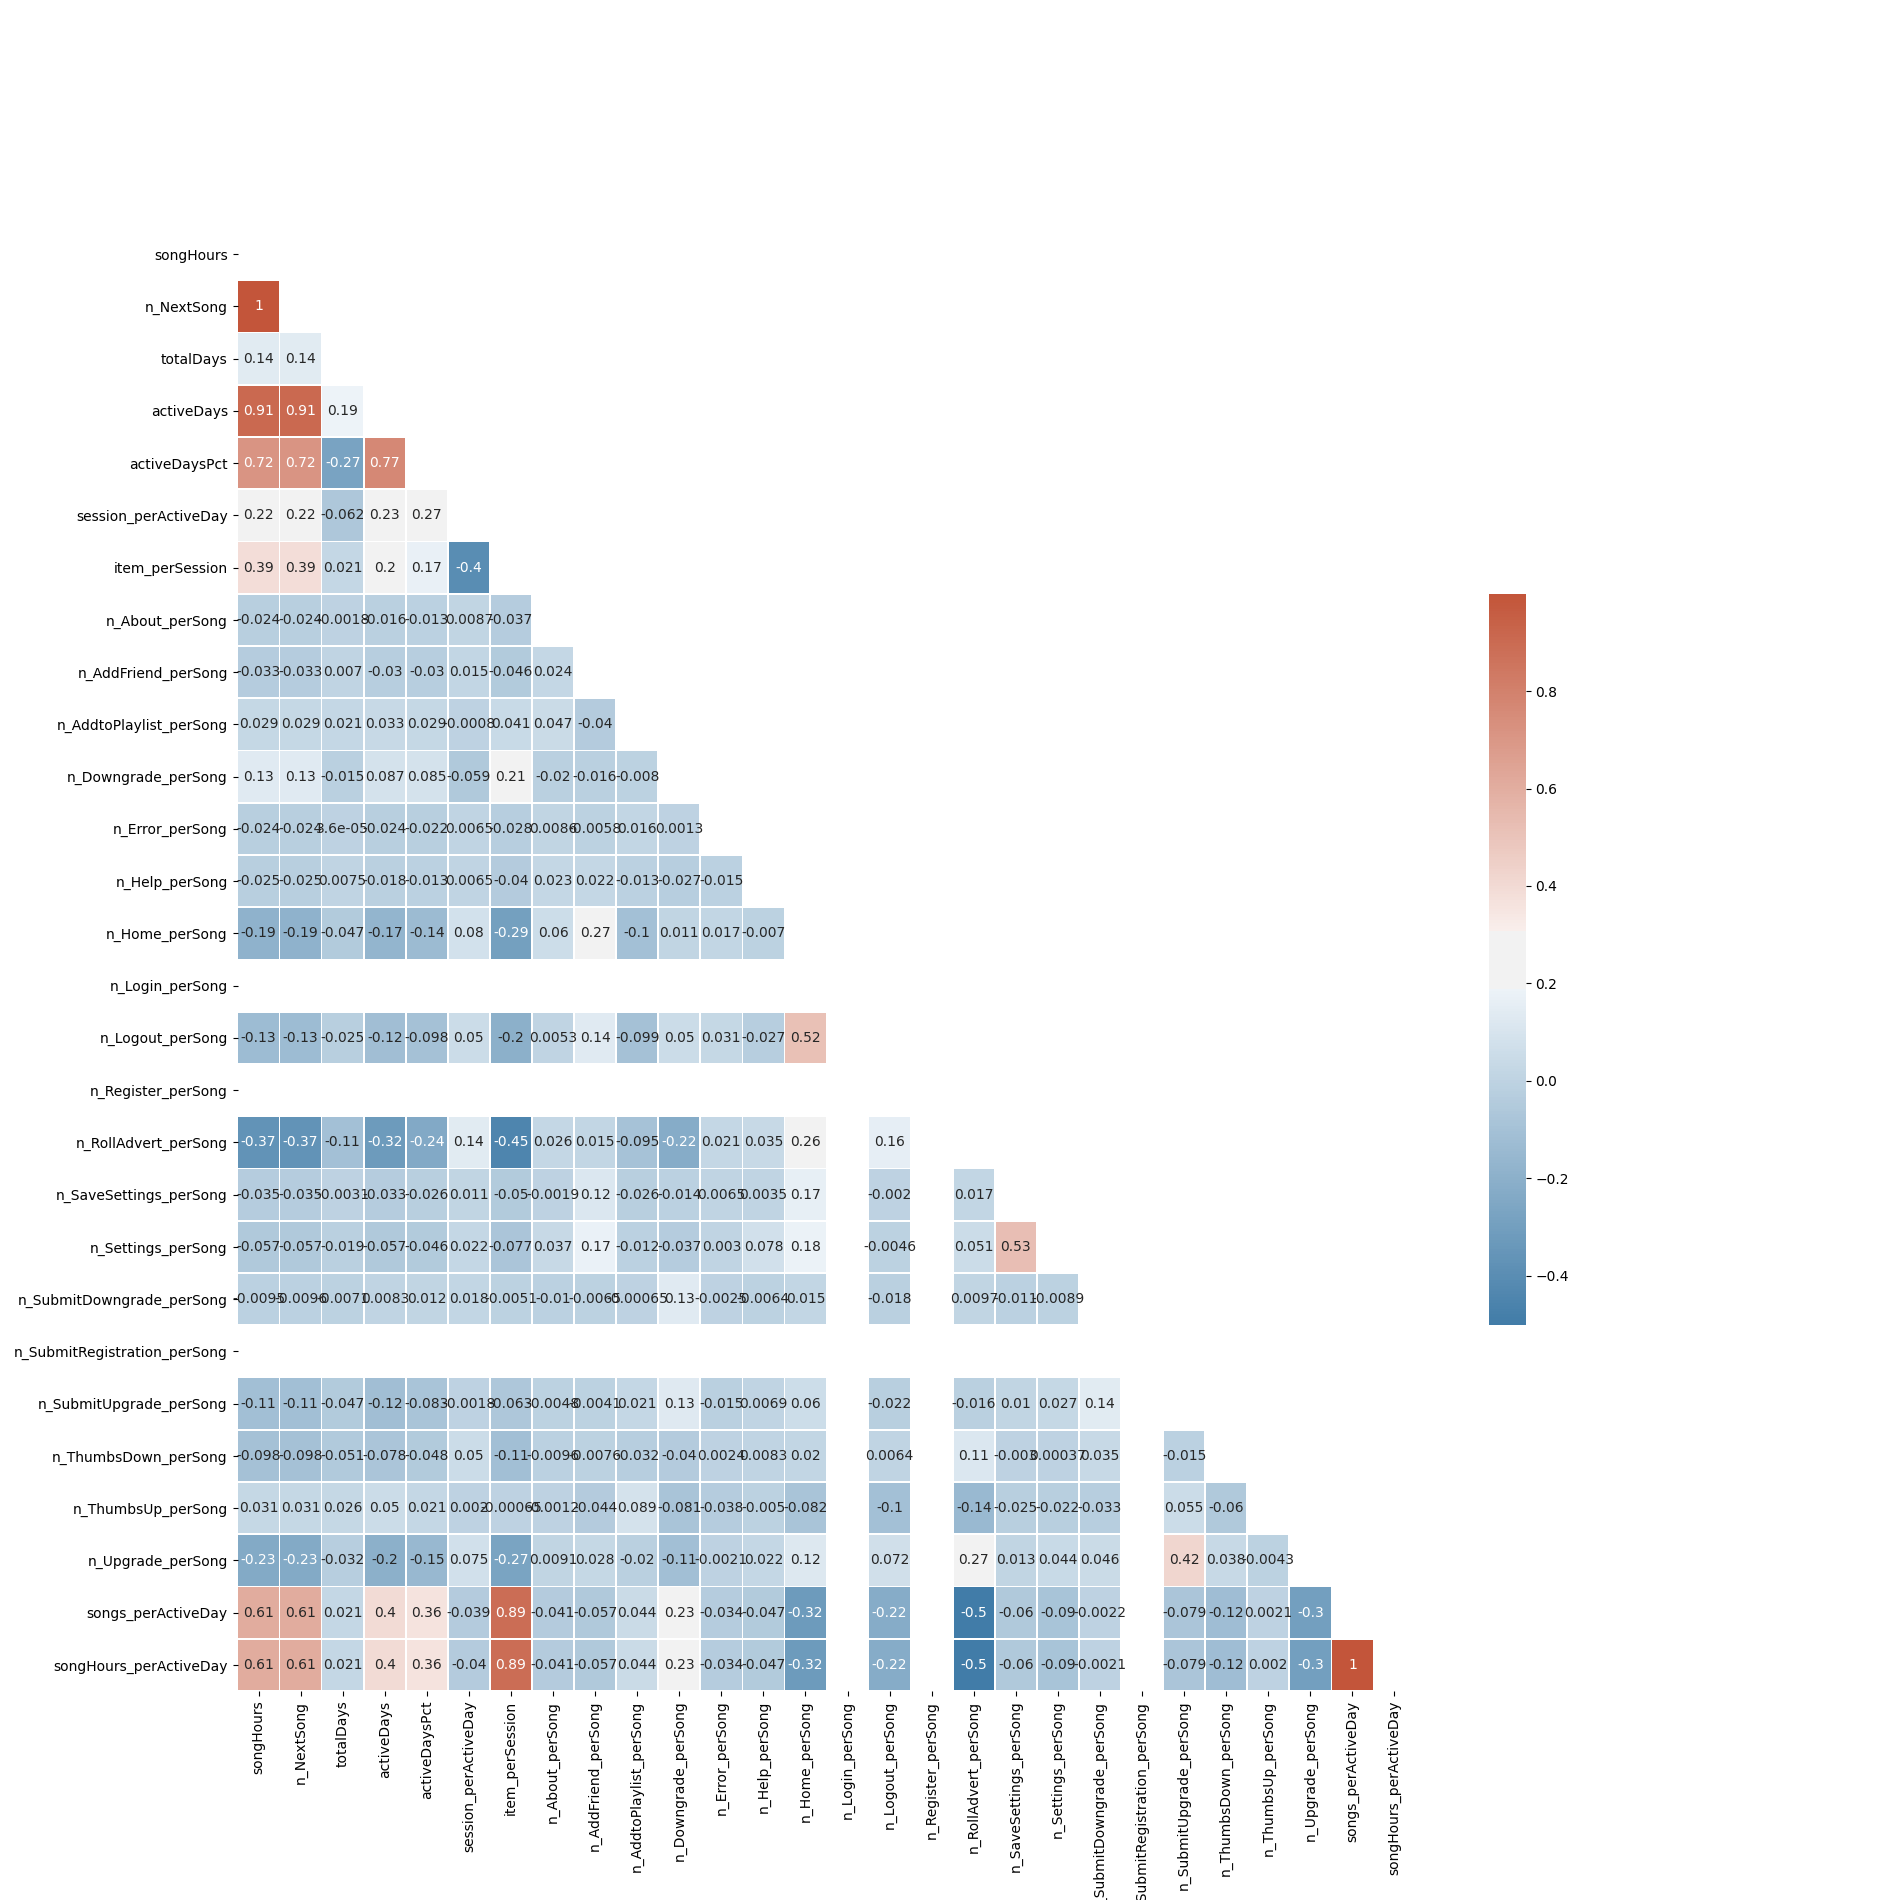

In [24]:
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (DoubleType, LongType))]

df_numeric_cols_panda = df.select(numeric_cols).toPandas()
corrMatrix = df_numeric_cols_panda.corr()

# Generate a mask for the upper triangle
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(240, 20, sep=20, n=20, as_cmap=True)
plt.figure(figsize=(19,19))
sn.heatmap(corrMatrix, annot=True, cmap=cmap, mask=mask, linewidths=.5, linecolor='white', cbar_kws={"shrink": .5})

# plt.show()
%matplot plt

### Drop features with correlation > 0.8

In [25]:
numeric_cols_drop = ['activeDays', 'n_NextSong', 'songHours', 'songs_perActiveDay', 'item_perSession']

# numeric columns after dropping high correlation features
numeric_cols = list(set(numeric_cols) - set(numeric_cols_drop))

df = df.drop(*numeric_cols_drop)

# categorical_cols = ['gender', 'registrationYearMonth', 'state', 'system', 'level']
# 'gender', 'system', 'level' were chosen as categorical features for further analysis as each of them has 2 or 3 levels. 
# categorical_cols = ['gender', 'system', 'level']
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
categorical_cols.remove('userId')

categorical_cols

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['gender', 'system', 'level']

In [26]:
# double check if there is any nan, Null or empty values in any column

df.select([count(when(isnan(c) | col(c).isNull() | (col(c)==""), c
                      )
                 ).alias(c) for c in df.columns]
          ).show()

# df.where(reduce(lambda x, y: x | y, (F.col(x).isNull() for x in df.columns))).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+------+------+-----+---------+-------------+--------------------+---------------+-------------------+-----------------------+-------------------+---------------+--------------+--------------+---------------+----------------+------------------+--------------------+----------------------+------------------+-------------------------+----------------------------+-----------------------+--------------------+------------------+-----------------+----------------------+
|userId|churn|gender|system|level|totalDays|activeDaysPct|session_perActiveDay|n_About_perSong|n_AddFriend_perSong|n_AddtoPlaylist_perSong|n_Downgrade_perSong|n_Error_perSong|n_Help_perSong|n_Home_perSong|n_Login_perSong|n_Logout_perSong|n_Register_perSong|n_RollAdvert_perSong|n_SaveSettings_perSong|n_Settings_perSong|n_SubmitDowngrade_perSong|n_SubmitRegistration_perSong|n_SubmitUpgrade_perSong|n_ThumbsDown_perSong|n_ThumbsUp_perSong|n_Upgrade_perSong|songHours_perActiveDay|
+------+-----+------+------+-----+----

### StringIndexer, Decoder and VectorAssembler

In [27]:
df = data_assembler_scaler(df, numeric_cols=numeric_cols, categorical_cols=categorical_cols)
df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[0.00881,0.04305,...|
|  0.0|[0.0,0.03431,0.0,...|
|  0.0|[0.0,0.068,0.0,55...|
|  0.0|[6.8E-4,0.04416,6...|
|  0.0|[0.00847,0.06356,...|
+-----+--------------------+
only showing top 5 rows

### Train test split

In [28]:
train, test = train_test_sampling(df)

print("Training Dataset records number: " + str(train.count()))
print("Test Dataset records number: " + str(test.count()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Dataset records number: 17736
Test Dataset records number: 4506

### Fit three models below.
**For unbalanced binary classification, 'areaUnderROC' is recommended as the 'evalator'.**
1. LogisticRegression
2. RandomForestClassifier
3. GBTClassifier

In [7]:
#1 logistic regression
lr = LogisticRegression()

# Create the parameter grid, add hyperparameters, and build the grid
grid1 = ParamGridBuilder() \
        .addGrid(lr.regParam, [0, 0.01, .1]) \
        .addGrid(lr.elasticNetParam, [0, .5, 1]) \
        .addGrid(lr.maxIter, [50, 100, 150]) \
        .build()

In [31]:
#2 RandomForestClassifier
rf = RandomForestClassifier()

# Create the parameter grid, add hyperparameters, and build the grid
grid2 = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 20, 30]) \
        .addGrid(rf.maxBins, [16, 32, 48]) \
        .addGrid(rf.maxDepth, [3, 5, 10]) \
        .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
#3 GBTClassifier
gbt = GBTClassifier()

# Create the parameter grid, add hyperparameters, and build the grid
grid3 = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [3, 5, 10]) \
        .addGrid(gbt.maxBins, [16, 32, 48]) \
        .addGrid(gbt.maxIter, [10, 20, 30]) \
        .build()

#         .addGrid(gbt.stepSize, [0.1, 0.5, 1])

In [29]:
evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderROC')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# get the best model, and model metrics for each model algorithm
lr_best_model, lr_model_metrics = best_model_and_all_metrics(base_model=lr, grid=grid1, \
                                                             evaluator=evaluator, data=df, numFolds=4, seed=42)
rf_best_model, rf_model_metrics = best_model_and_all_metrics(base_model=rf, grid=grid2, \
                                                             evaluator=evaluator, data=df, numFolds=4, seed=42)
gbt_best_model, gbt_model_metrics = best_model_and_all_metrics(base_model=gbt, grid=grid3, \
                                                             evaluator=evaluator, data=df, numFolds=4, seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
# save model
lr_best_model.save('lr_best_model.pkl')
rf_best_model.save('rf_best_model.pkl') 
gbt_best_model.save('gbt_best_model.pkl')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Compare model metrics
1. Comparing the metrics of three models, apparently, LogisticRegression has the worst metrics, in both train and test dataset, pretty much in every aspect. 
2. Compared to RandomForestClassifier, GBTClassifier has almost the same areaUnderROC, but slightly better F1 score. 

**Overall, the GBTClassifier is the best model in terms of F1 and areaUnderROC. The GBTClassifier does take more time to run than RandomForestClassifier.**

In [34]:
# combine model metrics into one pandas dataframe
pd.concat([lr_model_metrics, rf_model_metrics, gbt_model_metrics])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                    model     TRAIN                                \
                           accuracy precision    recall        F1   
0      LogisticRegression  0.826737  0.745799  0.345729  0.472446   
0  RandomForestClassifier  0.882950  0.933515  0.515075  0.663860   
0           GBTClassifier  0.867050  0.806964  0.535678  0.643914   

                    TEST                                             \
  areaUnderROC  accuracy precision    recall        F1 areaUnderROC   
0     0.809884  0.823125  0.736730  0.340196  0.465459     0.802923   
0     0.904375  0.841988  0.800781  0.401961  0.535248     0.835776   
0     0.882227  0.839991  0.736177  0.456863  0.563823     0.833191   

              TRAIN  
  training time (s)  
0        830.472881  
0       1010.639215  
0       1490.684941

### Feature Importance
The analysis was performed on the FULL dataset. For GBTClassifier, 
1. It seems most features related to page views per song are important. 
2. TotalDays, activeDaysPct, songHours_perActiveDay are the top 3 most important features, followed by n_RollAdvert_perSong, n_Downgrade_perSong, n_ThumbsUp_perSong, etc.. 
3. User systems (PC/Apple/Linux) and user gender (M/F) are the least important features.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

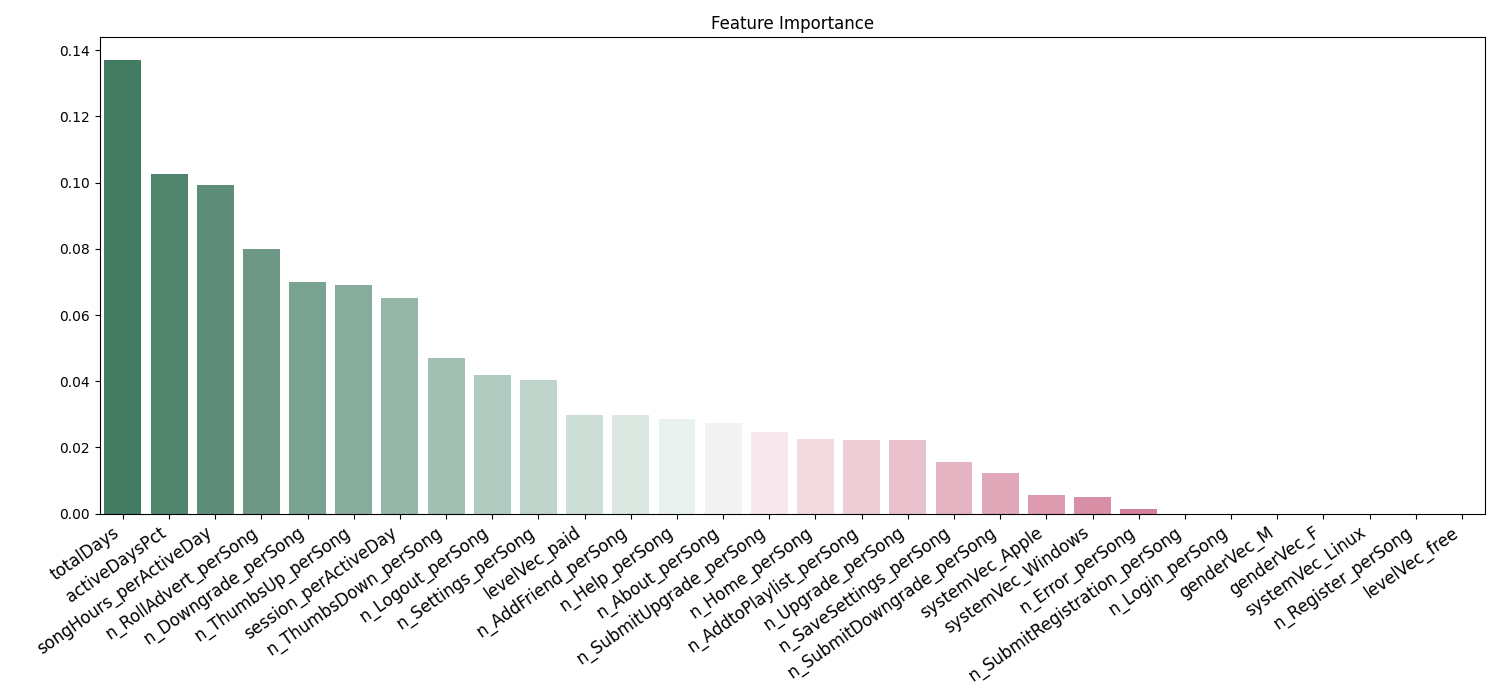

In [64]:
df_feature_importance = ExtractFeatureImp(gbt_best_model.featureImportances, df, "features")

# plot model's correlation coefficients
plt.figure(figsize=(15, 7));

palette = sn.diverging_palette(150, 0, n=27)

sn.barplot(x=df_feature_importance.name, y=df_feature_importance.score, data=df_feature_importance, palette=palette)
plt.xticks(rotation=35, ha='right', fontsize=12)
plt.title('Feature Importance')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

%matplot plt